### Home work № 7:

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import shap
import xgboost as xgb
import xgboost
import eli5

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
                            classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from scipy.io import arff


# load JS visualization code to notebook
shap.initjs()

%matplotlib inline

In [2]:
data = arff.loadarff('seismic-bumps.arff')
df = pd.DataFrame(data[0])

df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


In [3]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2578 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seismic         2578 non-null   object 
 1   seismoacoustic  2578 non-null   object 
 2   shift           2578 non-null   object 
 3   genergy         2578 non-null   float64
 4   gpuls           2578 non-null   float64
 5   gdenergy        2578 non-null   float64
 6   gdpuls          2578 non-null   float64
 7   ghazard         2578 non-null   object 
 8   nbumps          2578 non-null   float64
 9   nbumps2         2578 non-null   float64
 10  nbumps3         2578 non-null   float64
 11  nbumps4         2578 non-null   float64
 12  nbumps5         2578 non-null   float64
 13  nbumps6         2578 non-null   float64
 14  nbumps7         2578 non-null   float64
 15  nbumps89        2578 non-null   float64
 16  energy          2578 non-null   float64
 17  maxenergy       2578 non-null   f

In [5]:
df.loc[df['class'] == b'0', 'class'] = 0
df.loc[df['class'] == b'1', 'class'] = 1

df['class'] = df['class'].astype(int)

df['class'].value_counts(normalize=True)

0    0.934057
1    0.065943
Name: class, dtype: float64

In [6]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts(normalize=True)) + '\n')

seismic

b'a'    0.650116
b'b'    0.349884
Name: seismic, dtype: float64

seismoacoustic

b'a'    0.611327
b'b'    0.370054
b'c'    0.018619
Name: seismoacoustic, dtype: float64

shift

b'W'    0.644686
b'N'    0.355314
Name: shift, dtype: float64

ghazard

b'a'    0.906129
b'b'    0.082234
b'c'    0.011637
Name: ghazard, dtype: float64



In [7]:
TARGET_NAME = 'class'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

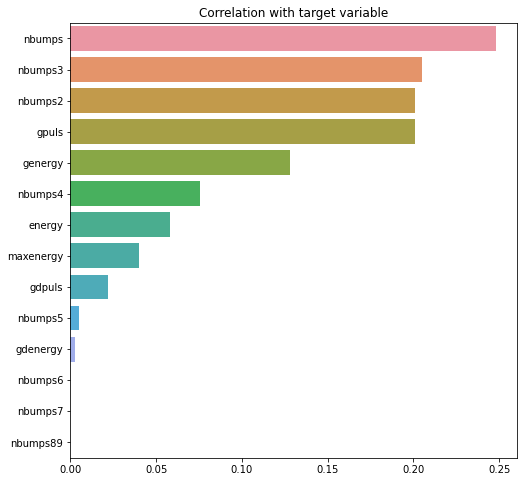

In [8]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(8, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

На целевую переменную больше всего влияет сам факт сейсмических ударов.

#### Energy feature grouped by target variable

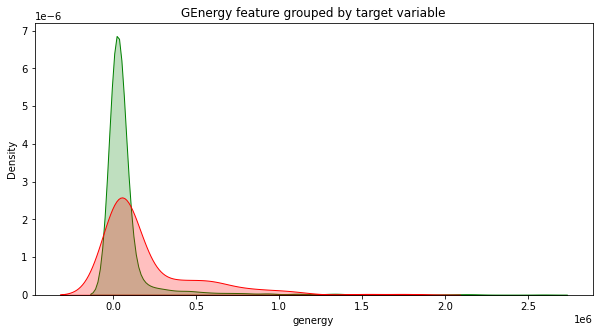

In [9]:
genergy_with_target_s = df[['genergy', TARGET_NAME]]
genergy_s = genergy_with_target_s['genergy']
genergy_target_0 = genergy_s[genergy_with_target_s[TARGET_NAME] == 0]
genergy_target_1 = genergy_s[genergy_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(genergy_target_0, shade=True, label='non-hazardous state', color='g')
sns.kdeplot(genergy_target_1, shade=True, label='hazardous state', color='r')

plt.xlabel('genergy')
plt.title('GEnergy feature grouped by target variable')
plt.show()

Опасные шахты характеризуются более частыми и энергетически высокими сейсмическими толчками.

#### Distribution of gpuls feature

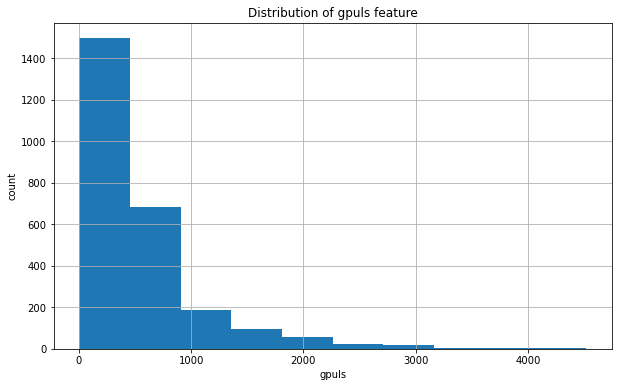

In [10]:
plt.figure(figsize = (10, 6))

plt.plot()
df['gpuls'].hist(bins=10)
plt.ylabel('count')
plt.xlabel('gpuls')
plt.title('Distribution of gpuls feature')
plt.show()

#### Purpose grouped by target variable

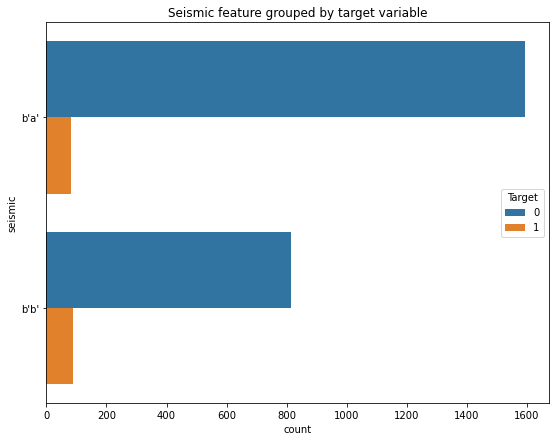

In [11]:
plt.figure(figsize=(9, 7))

sns.countplot(y="seismic", hue=TARGET_NAME, data=df, orient='h')
plt.title('Seismic feature grouped by target variable')
plt.legend(title='Target', loc='right')
plt.show()

Примерно в 2 раза больше точек отнесены к опасным среди класса 'b', чем класса 'a'. 

#### Feature engeneering

In [12]:
df['energy_on_nbumps'] = df['energy'] / df['nbumps']
df['energy_on_nbumps'].fillna(0, inplace=True)

df['genergy_on_gpuls'] = df['genergy'] / df['gpuls']
df['genergy_on_gpuls'].fillna(0, inplace=True)

In [13]:
median_genergy_by_ghazard = df.groupby(['ghazard'], as_index=False).agg({'genergy':'median'})\
                       .rename(columns={'genergy':'median_genergy_by_ghazard'})
df = df.merge(median_genergy_by_ghazard, on='ghazard', how='left')

median_genergy_by_ghazard

,ghazard,median_genergy_by_ghazard
0,b'a',24925.0
1,b'b',28720.0
2,b'c',39685.0


In [14]:
BASE_FEATURE_NAMES += ['median_genergy_by_ghazard', 'energy_on_nbumps', 'genergy_on_gpuls']

In [15]:
df.head(3)

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,...,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class,energy_on_nbumps,genergy_on_gpuls,median_genergy_by_ghazard
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,316.250000,24925.0
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,...,0.0,0.0,0.0,0.0,2000.0,2000.0,0,2000.0,446.060606,24925.0
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,268.333333,24925.0


### Обучение модели

In [16]:
# разделим данные на train/test (stratify, т.к. выборка не сбалансирована)
X_train, X_test, y_train, y_test = train_test_split(df[BASE_FEATURE_NAMES], df[TARGET_NAME], \
                                                    stratify=df[TARGET_NAME], random_state=42)  

In [17]:
#соберем наш pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [18]:
df.head(3)

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,...,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class,energy_on_nbumps,genergy_on_gpuls,median_genergy_by_ghazard
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,316.250000,24925.0
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,...,0.0,0.0,0.0,0.0,2000.0,2000.0,0,2000.0,446.060606,24925.0
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,268.333333,24925.0


In [19]:
categorical_columns = ['seismic', 'seismoacoustic', 'shift', 'ghazard']
continuous_columns = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'nbumps', \
                      'nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', \
                      'nbumps7', 'nbumps89', 'energy', 'maxenergy', \
                      'median_genergy_by_ghazard', 'energy_on_nbumps', 'genergy_on_gpuls']

In [20]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))  # Увеличивает число столбцов
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([('selector', NumberSelector(key=cont_col)), \
                                 ('scaler', StandardScaler())])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [21]:
pipeline_xgb = Pipeline([('features',feats), \
                         ('classifier', xgb.XGBClassifier(random_state = 42))])

In [22]:
params_xgb = dict(classifier__n_estimators=[300, 500, 800], \
                  classifier__max_depth=[2, 3, 5], \
                  classifier__learning_rate=[0.01, 0.1, 0.3])

In [23]:
def find_parameters(pipe, params):
    rs = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=5)  # Тут же делаем кросс-валидацию
    rs.fit(X_train, y_train.values.ravel())
    print(f"Model: {pipe['classifier']},\n params: {rs.best_params_},\n best_score: {rs.best_score_}\n\n")

In [24]:
%%time
find_parameters(pipeline_xgb, params_xgb)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...),
 params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 2, 'classifier__n_estimators': 500},
 best_score: 0.783589036451374


Wall time: 1min 46s


In [25]:
pipeline_xgb = Pipeline([('features',feats), \
                         ('classifier', xgb.XGBClassifier(max_depth=2, n_estimators=500, \
                                                          learning_rate=0.01, random_state = 42))])

In [26]:
%%time
#обучим пайплайн на всем тренировочном датасете
def fit_predict_models(pipe):
    pipe.fit(X_train, y_train)
    y_score = pipe.predict_proba(X_test)[:, 1]
    return y_score

y_score_xgb = fit_predict_models(pipeline_xgb)

Wall time: 730 ms


In [27]:
def metrics_calculation(y_test, preds, b=1):
    roc_auc = roc_auc_score(y_test, preds)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc

In [28]:
metrics_calculation(y_test, y_score_xgb)

(0.13501135,
 0.3283582089552239,
 0.24175824175824176,
 0.5116279069767442,
 0.7573205593757243)

#### Feature Importances property

In [29]:
X_train_ohe = pd.get_dummies(X_train, columns=categorical_columns)
X_train_ohe.head(3)

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,...,seismic_b'a',seismic_b'b',seismoacoustic_b'a',seismoacoustic_b'b',seismoacoustic_b'c',shift_b'N',shift_b'W',ghazard_b'a',ghazard_b'b',ghazard_b'c'
1645,29710.0,473.0,-18.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,1,1,0,0
1297,38560.0,741.0,237.0,166.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,0,1,0,0,0,1,1,0,0
2093,5280.0,178.0,-29.0,-16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,1,0,0


In [30]:
xgb_features = pd.DataFrame(pipeline_xgb[1].feature_importances_, X_train_ohe.columns, columns=['coefficient'])
xgb_features.head()

,coefficient
genergy,0.065256
gpuls,0.000000
gdenergy,0.007459
gdpuls,0.000000
nbumps,0.000000


#### Permutation importance

Признак считается «важным», если качество модели падает при его перемешивании. Один из вариантов - признаки по очереди обнуляются и замеряется изменение качества модели.

In [31]:
r = permutation_importance(pipeline_xgb, X_test, y_test, n_repeats=30, random_state=42)
r.importances_mean.argsort()[::-1]

array([ 5, 20,  9,  1,  2,  3,  4,  6,  7,  8, 10, 19, 11, 12, 13, 14, 15,
       16, 17, 18,  0], dtype=int64)

In [32]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{BASE_FEATURE_NAMES[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

gdenergy 0.000 +/- 0.001
genergy_on_gpuls 0.000 +/- 0.000
nbumps2  0.000 +/- 0.000
seismoacoustic 0.000 +/- 0.000
shift    0.000 +/- 0.000
genergy  0.000 +/- 0.000
gpuls    0.000 +/- 0.000
gdpuls   0.000 +/- 0.000
ghazard  0.000 +/- 0.000
nbumps   0.000 +/- 0.000
nbumps3  0.000 +/- 0.000
energy_on_nbumps 0.000 +/- 0.000
nbumps4  0.000 +/- 0.000
nbumps5  0.000 +/- 0.000
nbumps6  0.000 +/- 0.000
nbumps7  0.000 +/- 0.000
nbumps89 0.000 +/- 0.000
energy   0.000 +/- 0.000
maxenergy 0.000 +/- 0.000
median_genergy_by_ghazard 0.000 +/- 0.000
seismic  0.000 +/- 0.000


Все значения близки к нулю. Либо качество модели очень низкое, либо features вносят примерно одинаковый вклад по отдельности.

### SHAP

In [33]:
booster = xgboost.train({'learning_rate': 0.01, 'max_depth': 2, \
                         'random_state': 42}, xgboost.DMatrix(X_train_ohe, label=y_train), 100)
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_train_ohe)

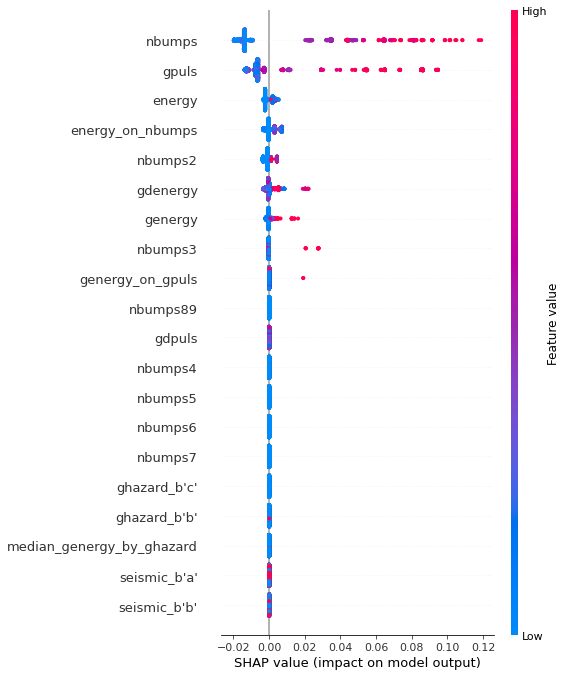

In [34]:
shap.summary_plot(shap_values, X_train_ohe)

- чем больше происходит толчков (nbumps, gpuls), тем больше вероятность того, что шахта будет признана опасной
- чем больше энергия таких толчков, тем опаснее шахта
- многие features не вносят вклад в прогноз

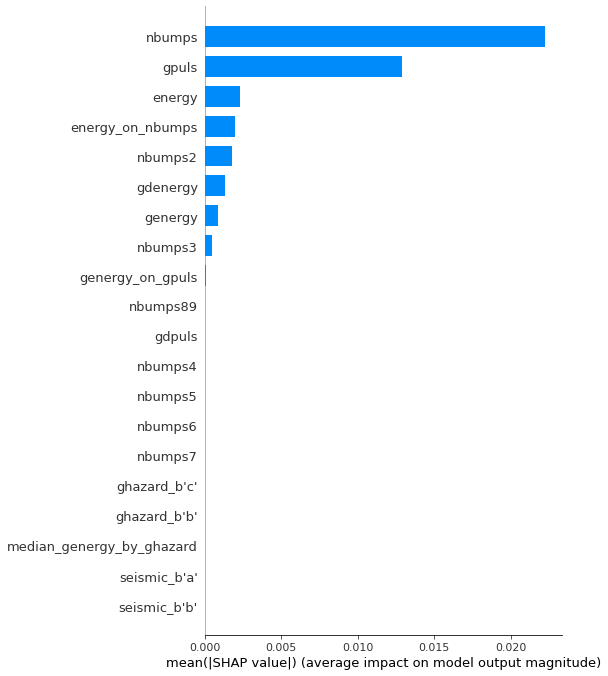

In [35]:
shap.summary_plot(shap_values, X_train_ohe, plot_type="bar")

In [36]:
shap.initjs()
#ten_percent = round(X_train_ohe.shape[0]*0.1)
list_choice = []
for i in range(5):
    list_choice.append(random.randint(0, X_train_ohe.shape[0]))
# Беру 5 случайных элементов выборки
shap.force_plot(explainer.expected_value, shap_values[list_choice], X_train_ohe.iloc[list_choice])